In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import squarify
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import metrics
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
warnings.filterwarnings('ignore')
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble

from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
from mpl_toolkits.mplot3d import Axes3D

C:\Users\LENOVO\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df=pd.read_excel('C:\\Users\\LENOVO\\Downloads\\Online Retail.xlsx')

In [3]:
df.shape

(541909, 8)

In [4]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.columns.unique()

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'],format='%Y%m%d')

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
df=df.dropna(subset=['CustomerID'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [10]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

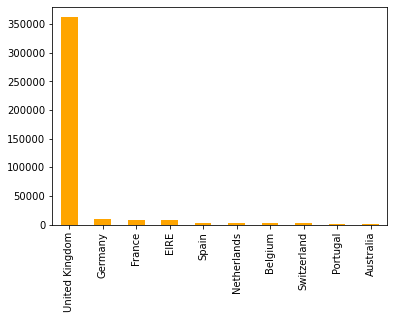

In [11]:
df.Country.value_counts().head(10).plot(kind='bar',color='orange')

In [12]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [13]:
df.shape

(401604, 8)

In [14]:
#The customer with the highest number of orders comes from the United Kingdom (UK)
y = df.groupby(['CustomerID','Country']).agg({'InvoiceNo' : 'count'}).sort_values(by = 'InvoiceNo', ascending = False)
y.head()

,,InvoiceNo
CustomerID,Country,
17841.0,United Kingdom,7812
14911.0,EIRE,5898
14096.0,United Kingdom,5128
12748.0,United Kingdom,4459
14606.0,United Kingdom,2759


In [15]:
df.Country.nunique()

37

In [16]:
#United Kingdom has the highest num of customers
customer_country=df[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False).head()

,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25


In [17]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [18]:
# Constucting a basket for later use
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})

In [19]:
nb_products_per_basket.InvoiceNo = nb_products_per_basket.InvoiceNo.astype(str)
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
len(nb_products_per_basket[nb_products_per_basket['order_canceled']==1])/len(nb_products_per_basket)*100

16.466876971608833

In [20]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1]

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346.0,C541433,1,1
23,12352.0,C545329,2,1
24,12352.0,C545330,1,1
25,12352.0,C547388,7,1
39,12359.0,C549955,2,1
...,...,...,...,...
22159,18274.0,C577832,11,1
22161,18276.0,C577386,1,1
22162,18276.0,C577390,1,1
22164,18277.0,C542086,1,1


In [21]:
nb_products_per_basket.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22190 entries, 0 to 22189
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          22190 non-null  float64
 1   InvoiceNo           22190 non-null  object 
 2   Number of products  22190 non-null  int64  
 3   order_canceled      22190 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 866.8+ KB


In [22]:
nb_products_per_basket.InvoiceNo = nb_products_per_basket.InvoiceNo.astype(str)
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
len(nb_products_per_basket[nb_products_per_basket['order_canceled']==1])/len(nb_products_per_basket)*100

16.466876971608833

In [23]:
df[df['CustomerID'] == 12346]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom


In [24]:
test = df[df['Quantity'] < 0][['CustomerID','Quantity', 'StockCode','Description','UnitPrice']]
for index, col in  test.iterrows():
    if df[(df['CustomerID'] == col[0]) & (df['Quantity'] == -col[1]) 
                & (df['Description'] == col[2])].shape[0] == 0: 
        print(test.loc[index])
        print('Our initial hypothesis is wrong')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
Our initial hypothesis is wrong


In [25]:
df[df['CustomerID'] == 14527].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527.0,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527.0,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527.0,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527.0,United Kingdom


In [26]:
data_check = df[(df['Quantity'] < 0) & (df['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  data_check.iterrows():
    if df[(df['CustomerID'] == col[0]) & (df['Quantity'] == -col[1]) 
                & (df['Description'] == col[2])].shape[0] == 0: 
        print(index, data_check.loc[index])
        print('The second hypothesis is also wrong')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
The second hypothesis is also wrong


In [27]:
df[(df['CustomerID'] == 15311) & (df['Description'] == 'SET OF 3 COLOURED  FLYING DUCKS')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311.0,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311.0,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311.0,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311.0,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311.0,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311.0,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311.0,United Kingdom


In [28]:
df_cleaned = df.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df[(df['CustomerID'] == col['CustomerID']) &
                         (df['StockCode']  == col['StockCode']) & 
                         (df['InvoiceDate'] < col['InvoiceDate']) & 
                         (df['Quantity']   > 0)].copy()
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break

In [29]:
df_test.shape[1]

8

In [30]:
len(entry_to_remove)

7521

In [31]:
len(doubtfull_entry)

1226

In [32]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358.0,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659.0,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048.0,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422.0,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754.0,United Kingdom,0


In [33]:
df_cleaned.drop(remaining_entries.index, axis = 0, inplace = True)
df_cleaned.shape

(392809, 9)

In [34]:
df_cleaned[df_cleaned['UnitPrice']==0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,0
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom,0
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom,0
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom,0
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom,0
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom,0


In [35]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True, na = False)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [36]:
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'POST']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'D']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'C2']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'M']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'BANK CHARGES']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'PADS']
df_cleaned = df_cleaned[df_cleaned['StockCode']!= 'DOT']

In [37]:
df_cleaned.shape

(391183, 9)

In [38]:
df_cleaned.describe()

,Quantity,UnitPrice,CustomerID,QuantityCanceled
count,391183.000000,391183.000000,391183.000000,391183.000000
mean,13.179665,2.874130,15295.083503,0.626569
std,181.907403,4.284639,1710.359579,175.902239
min,1.000000,0.000000,12346.000000,0.000000
25%,2.000000,1.250000,13969.000000,0.000000
50%,6.000000,1.950000,15158.000000,0.000000
75%,12.000000,3.750000,16794.000000,0.000000
max,80995.000000,649.500000,18287.000000,80995.000000


In [39]:
df_cleaned[(df_cleaned['UnitPrice'] == 0)].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,0


In [40]:
def unique_counts(data):
   for i in data.columns:
       count = data[i].nunique()
       print(i, ": ", count)
unique_counts(df_cleaned)

InvoiceNo :  18405
StockCode :  3659
Description :  3871
Quantity :  300
InvoiceDate :  17169
UnitPrice :  356
CustomerID :  4335
Country :  37
QuantityCanceled :  122


In [41]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])

In [42]:
#United Kingdom has the highest num of customers
customer_country=df[['Country','CustomerID']].drop_duplicates()
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False).head()

,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25


Text(0.5, 1.0, 'Revenue per Country')

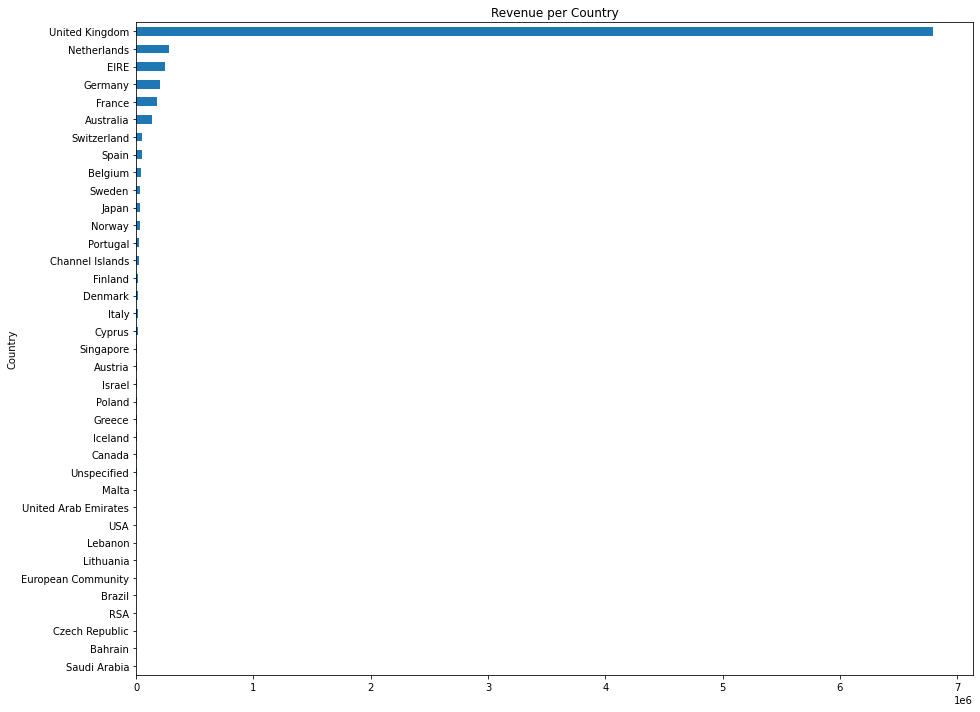

In [43]:
revenue_per_countries = df_cleaned.groupby(["Country"])["TotalPrice"].sum().sort_values()
revenue_per_countries.plot(kind='barh', figsize=(15,12))
plt.title("Revenue per Country")

Text(0.5, 1.0, 'Number of Invoices per Country')

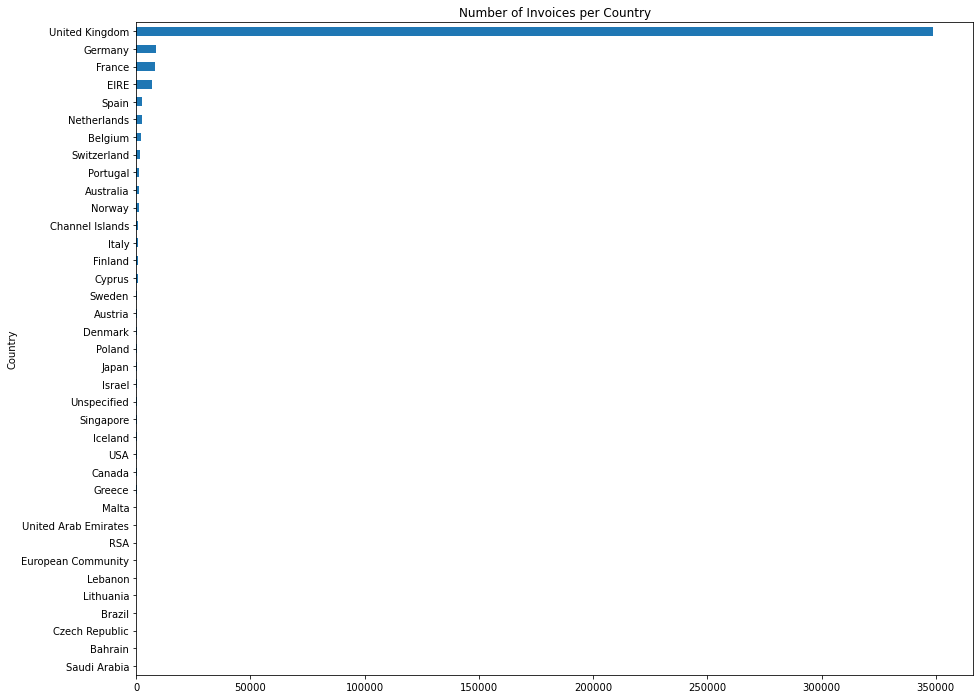

In [44]:
No_invoice_per_country = df_cleaned.groupby(["Country"])["InvoiceNo"].count().sort_values()
No_invoice_per_country.plot(kind='barh', figsize=(15,12))
plt.title("Number of Invoices per Country")

In [45]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34


In [46]:
#Netherlands has the highest average expenditure.
df_cleaned.groupby(['Country']).agg({'TotalPrice':np.mean}).sort_values(by='TotalPrice',ascending=False).head(5)

,TotalPrice
Country,
Netherlands,121.858788
Australia,115.765216
Japan,110.344424
Sweden,85.159040
Denmark,49.161144


In [47]:
snapshot_date = df_cleaned['InvoiceDate'].max() + timedelta(days=1)
print(snapshot_date)

2011-12-10 12:50:00


In [48]:
# Grouping by CustomerID
data_process = df_cleaned.groupby(['CustomerID']).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'count',
        'TotalPrice': 'sum'})
# Rename the columns 
data_process.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalPrice': 'MonetaryValue'}, inplace=True)

In [49]:
data_process

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,0.00
12347.0,2,182,4310.00
12348.0,75,27,1437.24
12349.0,19,72,1457.55
12350.0,310,16,294.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,12,176.60


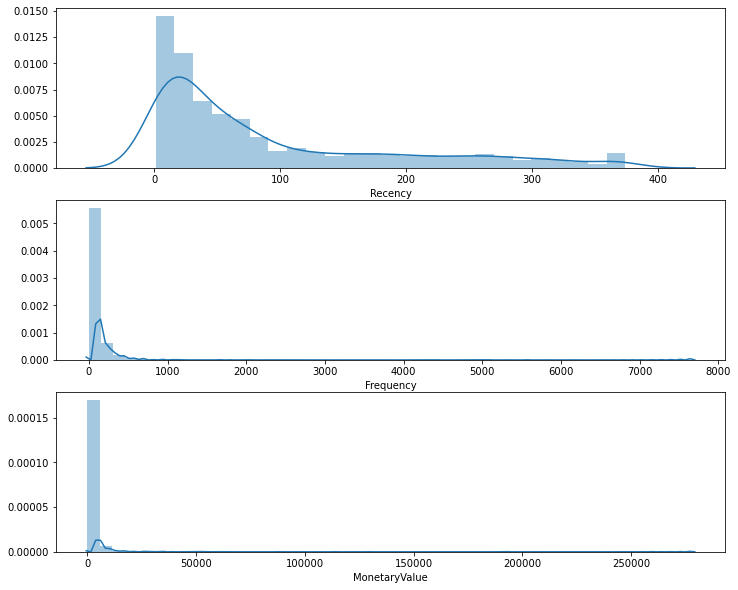

In [50]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(data_process['Recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(data_process['Frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(data_process['MonetaryValue'])
# Show the plot
plt.show()

In [51]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(data_process['Frequency'], q=4, labels=f_labels)
# Create new columns R and F 
data_process = data_process.assign(R = r_groups.values, F = f_groups.values)
data_process.head()

,Recency,Frequency,MonetaryValue,R,F
CustomerID,,,,,
12346.0,326,1,0.00,1,1
12347.0,2,182,4310.00,4,4
12348.0,75,27,1437.24,2,2
12349.0,19,72,1457.55,3,3
12350.0,310,16,294.40,1,1


In [52]:
# --Calculate R and F groups--
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(data_process['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(data_process['Frequency'], q=4, labels=f_labels)
# Create new columns R and F 
data_process = data_process.assign(R = r_groups.values, F = f_groups.values)
data_process.head()

,Recency,Frequency,MonetaryValue,R,F
CustomerID,,,,,
12346.0,326,1,0.00,1,1
12347.0,2,182,4310.00,4,4
12348.0,75,27,1437.24,2,2
12349.0,19,72,1457.55,3,3
12350.0,310,16,294.40,1,1


In [53]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(data_process['MonetaryValue'], q=4, labels=m_labels)
# Create new column M
data_process = data_process.assign(M = m_groups.values)

In [54]:
data_process.head(5)

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12346.0,326,1,0.00,1,1,1
12347.0,2,182,4310.00,4,4,4
12348.0,75,27,1437.24,2,2,3
12349.0,19,72,1457.55,3,3,3
12350.0,310,16,294.40,1,1,1


In [55]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
data_process['RFM_Segment_Concat'] = data_process.apply(join_rfm, axis=1)
rfm = data_process
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat
CustomerID,,,,,,,
12346.0,326,1,0.00,1,1,1,111
12347.0,2,182,4310.00,4,4,4,444
12348.0,75,27,1437.24,2,2,3,223
12349.0,19,72,1457.55,3,3,3,333
12350.0,310,16,294.40,1,1,1,111


In [56]:
# Count num of unique segments
rfm_count_unique = rfm.groupby('RFM_Segment_Concat')['RFM_Segment_Concat'].nunique()
print(rfm_count_unique.sum())


62


In [57]:
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
print(rfm['RFM_Score'].head())

CustomerID
12346.0     3.0
12347.0    12.0
12348.0     7.0
12349.0     9.0
12350.0     3.0
Name: RFM_Score, dtype: float64


In [58]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
12346.0,326,1,0.00,1,1,1,111,3.0,Require Activation
12347.0,2,182,4310.00,4,4,4,444,12.0,Can't Loose Them
12348.0,75,27,1437.24,2,2,3,223,7.0,Loyal
12349.0,19,72,1457.55,3,3,3,333,9.0,Can't Loose Them
12350.0,310,16,294.40,1,1,1,111,3.0,Require Activation


In [59]:
rfm.sort_values(by='RFM_Score',ascending=False)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment_Concat,RFM_Score,RFM_Level
CustomerID,,,,,,,,,
17091.0,3,195,3802.81,4,4,4,444,12.0,Can't Loose Them
17602.0,2,551,5002.22,4,4,4,444,12.0,Can't Loose Them
16712.0,9,437,3603.66,4,4,4,444,12.0,Can't Loose Them
13588.0,16,174,2449.92,4,4,4,444,12.0,Can't Loose Them
15615.0,10,423,10369.99,4,4,4,444,12.0,Can't Loose Them
...,...,...,...,...,...,...,...,...,...
14117.0,144,3,90.00,1,1,1,111,3.0,Require Activation
14840.0,268,4,62.85,1,1,1,111,3.0,Require Activation
12837.0,173,12,134.10,1,1,1,111,3.0,Require Activation


In [60]:
rfm2=rfm[['Recency','Frequency','MonetaryValue']]

In [61]:
rfm2.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,0.00
12347.0,2,182,4310.00
12348.0,75,27,1437.24
12349.0,19,72,1457.55
12350.0,310,16,294.40


In [62]:
rfm2.describe()

,Recency,Frequency,MonetaryValue
count,4335.000000,4335.000000,4335.000000
mean,92.684890,90.238293,1906.249825
std,100.172622,224.712166,8303.329919
min,1.000000,1.000000,0.000000
25%,18.000000,17.000000,298.160000
50%,51.000000,41.000000,650.750000
75%,143.000000,98.000000,1605.750000
max,374.000000,7667.000000,278742.020000


In [63]:
sc=StandardScaler()

In [64]:
rfm2_scaled=sc.fit_transform(rfm2)
rfm2_df=pd.DataFrame(rfm2_scaled,columns=rfm2.columns)
rfm2_df.head()

,Recency,Frequency,MonetaryValue
0,2.329399,-0.397168,-0.229603
1,-0.905391,0.408399,0.289526
2,-0.176565,-0.281452,-0.056491
3,-0.735664,-0.081172,-0.054045
4,2.169656,-0.330409,-0.194143


In [119]:
kmeans=KMeans(n_clusters=3,n_init=100,random_state=123)
kmeans.fit(rfm2_df)

KMeans(n_clusters=3, n_init=100, random_state=123)

In [120]:
kmeans.cluster_centers_

array([[-5.12963104e-01,  4.75997973e-02,  2.82960146e-03,
         1.14572399e+00],
       [-8.73134880e-01,  1.13936323e+01,  1.34618335e+01,
         2.92307692e+00],
       [ 1.54463365e+00, -2.79125543e-01, -1.70054400e-01,
        -1.99840144e-15]])

In [121]:
pd.DataFrame(kmeans.cluster_centers_,columns=rfm2_df.columns)

,Recency,Frequency,MonetaryValue,labels
0,-0.512963,0.047600,0.002830,1.145724e+00
1,-0.873135,11.393632,13.461834,2.923077e+00
2,1.544634,-0.279126,-0.170054,-1.998401e-15


In [122]:
rfm2_predict=kmeans.predict(rfm2_df)

In [123]:
rfm2_df['labels']=rfm2_predict

In [124]:
rfm2_df['labels'].value_counts()

0    3239
2    1083
1      13
Name: labels, dtype: int64

In [125]:
rfm2['labels']=rfm2_predict

In [127]:
rfm2

,Recency,Frequency,MonetaryValue,labels
CustomerID,,,,
12346.0,326,1,0.00,2
12347.0,2,182,4310.00,0
12348.0,75,27,1437.24,0
12349.0,19,72,1457.55,0
12350.0,310,16,294.40,2
...,...,...,...,...
18280.0,278,10,180.60,2
18281.0,181,7,80.82,2
18282.0,8,12,176.60,0


In [129]:
rfm2.groupby('labels').agg({'Recency':np.mean,'Frequency':np.mean,'MonetaryValue':[np.mean,'count']})

Recency    Frequency  MonetaryValue      
              mean         mean           mean count
labels                                              
0        41.305959   100.933313    1929.742229  3239
1         5.230769  2650.230769  113671.401538    13
2       247.397045    27.522622     494.394912  1083

In [71]:
rfm2_df.iloc[:,0]

0       2.329399
1      -0.905391
2      -0.176565
3      -0.735664
4       2.169656
          ...   
4330    1.850171
4331    0.881731
4332   -0.845487
4333   -0.885423
4334   -0.496050
Name: Recency, Length: 4335, dtype: float64

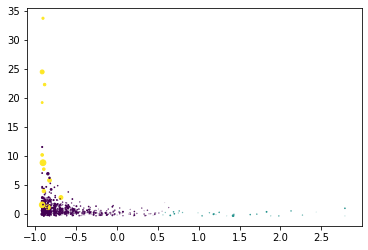

In [72]:
plt.scatter(rfm2_df.iloc[:,0],rfm2_df.iloc[:,1],rfm2_df.iloc[:,2],c=rfm2_df.labels)

In [130]:
silhouette_score(rfm2_df,rfm2_predict)

0.7231989467872778

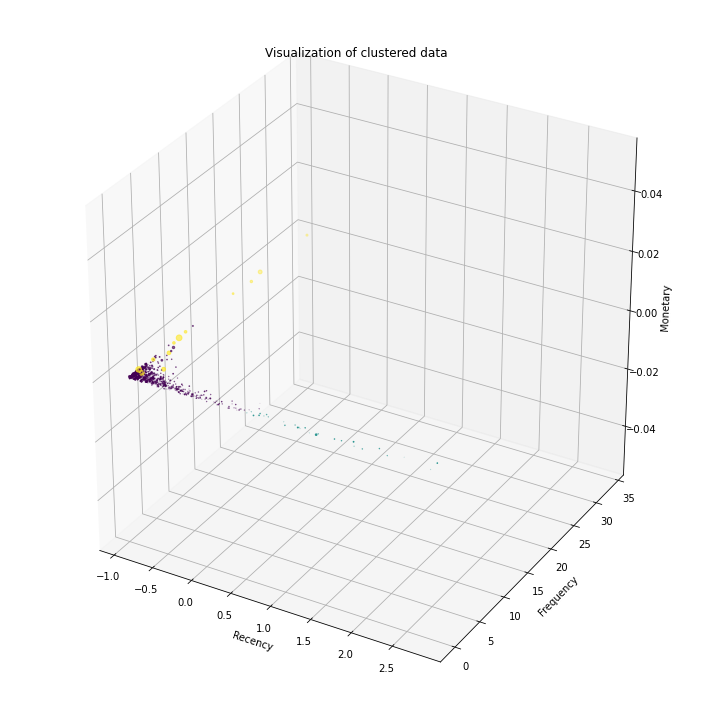

In [74]:
fig=plt.figure(figsize=(10,10))
ax2 = fig.add_subplot(111, projection='3d')
plt.scatter(rfm2_df.iloc[:,0],rfm2_df.iloc[:,1],rfm2_df.iloc[:,2],c=rfm2_df.labels)
ax2.set_title('Visualization of clustered data')
ax2.set_xlabel('Recency')
ax2.set_ylabel('Frequency')
ax2.set_zlabel('Monetary')

plt.tight_layout()
plt.show()

In [75]:
#clv

In [76]:
df_cleaned.shape

(391183, 10)

In [77]:
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0,16.60


In [78]:
df_data_group=df_cleaned.groupby('CustomerID').agg({'InvoiceDate': lambda date: (date.max() - date.min()).days,
                                        'InvoiceNo': lambda num: len(num),
                                        'Quantity': lambda quant: quant.sum(),
                                        'TotalPrice': lambda price: price.sum()})

In [79]:
# Change the name of columns
df_data_group.columns=['num_days','num_transactions','num_units','spent_money']
df_data_group.head()

,num_days,num_transactions,num_units,spent_money
CustomerID,,,,
12346.0,0,1,74215,0.00
12347.0,365,182,2458,4310.00
12348.0,282,27,2332,1437.24
12349.0,0,72,630,1457.55
12350.0,0,16,196,294.40


In [80]:
df_data_group['avg_order_value']=df_data_group['spent_money']/df_data_group['num_transactions']

In [81]:
purchase_frequency=sum(df_data_group['num_transactions'])/df_data_group.shape[0]

In [82]:
df_data_group

,num_days,num_transactions,num_units,spent_money,avg_order_value
CustomerID,,,,,
12346.0,0,1,74215,0.00,0.000000
12347.0,365,182,2458,4310.00,23.681319
12348.0,282,27,2332,1437.24,53.231111
12349.0,0,72,630,1457.55,20.243750
12350.0,0,16,196,294.40,18.400000
...,...,...,...,...,...
18280.0,0,10,45,180.60,18.060000
18281.0,0,7,54,80.82,11.545714
18282.0,118,12,103,176.60,14.716667


In [83]:
repeat_rate=df_data_group[df_data_group.num_transactions > 1].shape[0]/df_data_group.shape[0]

In [84]:
repeat_rate

0.9829296424452134

In [85]:
churn_rate=1-repeat_rate

In [86]:
print(purchase_frequency)
print(repeat_rate)
print(churn_rate)

90.23829296424452
0.9829296424452134
0.017070357554786586


In [87]:
# Profit Margin
df_data_group['profit_margin']=df_data_group['spent_money']*0.05

In [88]:
df_data_group.head()


,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin
CustomerID,,,,,,
12346.0,0,1,74215,0.00,0.000000,0.0000
12347.0,365,182,2458,4310.00,23.681319,215.5000
12348.0,282,27,2332,1437.24,53.231111,71.8620
12349.0,0,72,630,1457.55,20.243750,72.8775
12350.0,0,16,196,294.40,18.400000,14.7200


In [89]:
df_data_group['CLV']=(df_data_group['avg_order_value']*purchase_frequency)/churn_rate

In [90]:
df_data_group['cust_lifetime_value']=df_data_group['CLV']*df_data_group['profit_margin']

In [91]:
df_data_group.head()


,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value
CustomerID,,,,,,,,
12346.0,0,1,74215,0.00,0.000000,0.0000,0.000000,0.000000e+00
12347.0,365,182,2458,4310.00,23.681319,215.5000,125185.530888,2.697748e+07
12348.0,282,27,2332,1437.24,53.231111,71.8620,281393.320781,2.022149e+07
12349.0,0,72,630,1457.55,20.243750,72.8775,107013.660220,7.798888e+06
12350.0,0,16,196,294.40,18.400000,14.7200,97267.124324,1.431772e+06


In [92]:
df_cleaned['month_yr'] = df_cleaned['InvoiceDate'].apply(lambda x: x.strftime('%b-%Y'))

In [93]:
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,month_yr
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,Dec-2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,Dec-2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,Dec-2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,Dec-2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,Dec-2010
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0,10.20,Dec-2011
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0,12.60,Dec-2011
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0,16.60,Dec-2011
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0,16.60,Dec-2011


In [94]:
sale=df_cleaned.pivot_table(index=['CustomerID'],columns=['month_yr'],values='TotalPrice',aggfunc='sum',fill_value=0).reset_index()


In [95]:
sale

month_yr,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011
0,12346.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0
1,12347.0,636.25,584.91,711.79,224.82,0.00,475.39,0.00,382.52,0.0,0.00,0.00,1294.32,0.0
2,12348.0,327.00,0.00,652.80,0.00,0.00,187.44,0.00,0.00,0.0,0.00,0.00,0.00,270.0
3,12349.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1457.55,0.00,0.0
4,12350.0,0.00,0.00,0.00,0.00,294.40,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4330,18280.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,180.6,0.00,0.00,0.00,0.0
4331,18281.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,80.82,0.0,0.00,0.00,0.00,0.0
4332,18282.0,0.00,98.76,0.00,77.84,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0
4333,18283.0,113.65,0.00,0.00,208.00,100.95,213.75,139.89,296.52,0.0,85.22,637.71,112.99,130.9


In [96]:
sale['CLV']=sale.iloc[:,2:].sum(axis=1)

In [97]:
sale.head(5)

month_yr,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011,CLV
0,12346.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00
1,12347.0,636.25,584.91,711.79,224.82,0.0,475.39,0.0,382.52,0.0,0.0,0.00,1294.32,0.0,3673.75
2,12348.0,327.00,0.00,652.80,0.00,0.0,187.44,0.0,0.00,0.0,0.0,0.00,0.00,270.0,1110.24
3,12349.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,1457.55,0.00,0.0,1457.55
4,12350.0,0.00,0.00,0.00,0.00,294.4,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,294.40


In [98]:
X=sale[['Dec-2011','Nov-2011', 'Oct-2011','Sep-2011','Aug-2011','Jul-2011']]
y=sale[['CLV']]

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

In [100]:
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

In [101]:
print(linreg.intercept_)
print(linreg.coef_)

[38.93372582]
[[1.74024252 0.84675452 1.95698515 1.32780326 2.88765616 2.04804599]]


In [102]:
print("R-Square:",metrics.r2_score(y_test, y_pred))

R-Square: 0.8845554009786056
